# Image relevancy to natural disaster event

Binary classifier to identify if an image is relevant or not to natural disaster event such earthquake.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import gc
import math
import wget
import tarfile
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks,models,layers
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator



## Uncomment those lines if you have a GPU

In [2]:
# Uncomment those lines if you have gpu.
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
# Working Directory
cwd = os.getcwd()
cwd

'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\notebooks'

You can simply assign the working directory to be 'one level above the current directory' by running this line of code with the `..` as the path. 
  
`..` means 'one directory above the current directory.You should be in the noteboks directory, we need to download extract data one level above in the `data` folder.

**Note you should only run it once! If you run it multiple times, you will keep reseting the working directory to one level above the current directory, until you reach the root of the drive!**

In [4]:
# Set Working Directory (if needed)
# you can just do this:
os.chdir(r"..") 

In [5]:
# Confirm it changed the working Directory
print("My working directory:\n" + os.getcwd())
cwd = os.getcwd()
cwd

My working directory:
c:\Users\wsn8\Code\disaster-damage-assessment-ml


'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml'

In [6]:
## Download the data

In [7]:
IMAGE_FOLDER = 'ASONAM17_Damage_Image_Dataset'
FILENAME = 'ASONAM17_Damage_Image_Dataset.tar.gz'
DATA_PATH = os.path.join(cwd, 'data')
DAMAGE_PATH = os.path.join(DATA_PATH, 'damage_csv')
IMAGES_PATH = os.path.join(cwd,'data',IMAGE_FOLDER)
FILE_PATH = os.path.join(cwd,'data',FILENAME)
DATA_PATH,IMAGES_PATH,FILE_PATH

('c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data',
 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset',
 'c:\\Users\\wsn8\\Code\\disaster-damage-assessment-ml\\data\\ASONAM17_Damage_Image_Dataset.tar.gz')

In [8]:
def download_images(target_path):
    url = 'https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz'
    target_path = target_path
    filename = wget.download(url=url, out=target_path)
    return filename

def extract_images(target_path, filename='ASONAM17_Damage_Image_Dataset.tar.gz'):

    print(target_path + filename)

    tar = tarfile.open(target_path+filename)
    tar.extractall(path=target_path)
    tar.close()

In [9]:
# check if folder or images already exits first
if os.path.isdir(IMAGES_PATH) and os.path.exists(FILE_PATH):
    print("data already downloaded and extracted ")
else:
    print("downloading and extracting images data")
    filename = download_images(DATA_PATH)
    extract_images(target_path=DATA_PATH, filename=filename)

data already downloaded and extracted 


## Get data and convert image path and label to csv

In [10]:
relevance_list=[]
for split in ['train.csv','test.csv','dev.csv']:
    df = pd.read_csv(os.path.join(DATA_PATH,'damage_csv','cross_event_ecuador',split))
    relevance_list.append(df)

pd.concat(relevance_list)

,path,label
0,nepal_eq/nepal_eq_none_im_5522.jpg,0
1,nepal_eq/nepal_eq_severe_im_12790.jpg,2
2,nepal_eq/nepal_eq_severe_im_36185.jpg,2
3,nepal_eq/nepal_eq_none_im_37629.jpg,0
4,nepal_eq/nepal_eq_mild_im_10018.jpg,1
...,...,...
451,ecuador_eq/ecuador_eq_unlabelled_im_952.jpg,2
452,ecuador_eq/ecuador_eq_unlabelled_im_954.jpg,2
453,ecuador_eq/ecuador_eq_unlabelled_im_956.jpg,2
454,ecuador_eq/ecuador_eq_unlabelled_im_965.jpg,0


In [11]:
df_train = pd.read_csv(os.path.join(DATA_PATH,'damage_csv','cross_event_ecuador','train.csv'))
df_dev = pd.read_csv(os.path.join(DATA_PATH,'damage_csv','cross_event_ecuador','dev.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH,'damage_csv','cross_event_ecuador','test.csv'))

In [12]:
df_train,df_dev,df_test

(                                              path  label
 0               nepal_eq/nepal_eq_none_im_5522.jpg      0
 1            nepal_eq/nepal_eq_severe_im_12790.jpg      2
 2            nepal_eq/nepal_eq_severe_im_36185.jpg      2
 3              nepal_eq/nepal_eq_none_im_37629.jpg      0
 4              nepal_eq/nepal_eq_mild_im_10018.jpg      1
 ...                                            ...    ...
 14629     ecuador_eq/ecuador_eq_severe_im_1027.jpg      2
 14630       ecuador_eq/ecuador_eq_none_im_1910.jpg      0
 14631       ecuador_eq/ecuador_eq_none_im_1935.jpg      0
 14632  ecuador_eq/ecuador_eq_unlabelled_im_139.jpg      2
 14633       ecuador_eq/ecuador_eq_none_im_2055.jpg      0
 
 [14634 rows x 2 columns],
                                             path  label
 0          ecuador_eq/ecuador_eq_mild_im_121.jpg      1
 1         ecuador_eq/ecuador_eq_mild_im_1294.jpg      1
 2         ecuador_eq/ecuador_eq_mild_im_1707.jpg      1
 3         ecuador_eq/ecuador_eq_mi

In [13]:
def compute_relevant_label(df):
    df['relevant'] = df['label'].apply(lambda x: 1 if x in [1,2] else 0)
    df = df.drop('label',axis=1)
    return df

df_train_rel = compute_relevant_label(df_train)
df_dev_rel = compute_relevant_label(df_dev)
df_test_rel = compute_relevant_label(df_test)

os.makedirs(os.path.join(DAMAGE_PATH,'relevance'),exist_ok=True)
df_train_rel.to_csv(os.path.join(DAMAGE_PATH,'relevance','train.csv'),index=False)
df_dev_rel.to_csv(os.path.join(DAMAGE_PATH,'relevance','dev.csv'),index=False)
df_test_rel.to_csv(os.path.join(DAMAGE_PATH,'relevance','test.csv'),index=False)



**Function to Create Dataset**

In [14]:

DATA_RELEVANCE = os.path.join(DAMAGE_PATH,'relevance')
IMG_SIZE = 224


data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100,frac=0.1,seed=42):


    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']
    train_df = train_df.sample(frac=frac,random_state=seed)

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']
    valid_df = valid_df.sample(frac=frac,random_state=seed)

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']
    test_df = test_df.sample(frac=frac,random_state=seed)

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=IMAGES_PATH,
                                x_col='path',
                                y_col='label',
                                class_mode='raw', 
                                shuffle= False,           
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
           
        
    steps_per_epoch = compute_steps_per_epoch(len(train_df)) 
    validation_steps = compute_steps_per_epoch(len(valid_df))
    
    print(f"steps_per_epochs: { steps_per_epoch}")
    print(f"validations_steps: { validation_steps}")
    
    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps

In [15]:
train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(DAMAGE_PATH,'relevance',
                                    is_augment=False,batch_size=32,buffer_size=100,frac=0.1)

Found 1464 validated image filenames.
Found 46 validated image filenames.
Found 46 validated image filenames.
steps_per_epochs: 46
validations_steps: 2


## Visualize Data

In [16]:
class_names=['non-relevant','relevant']

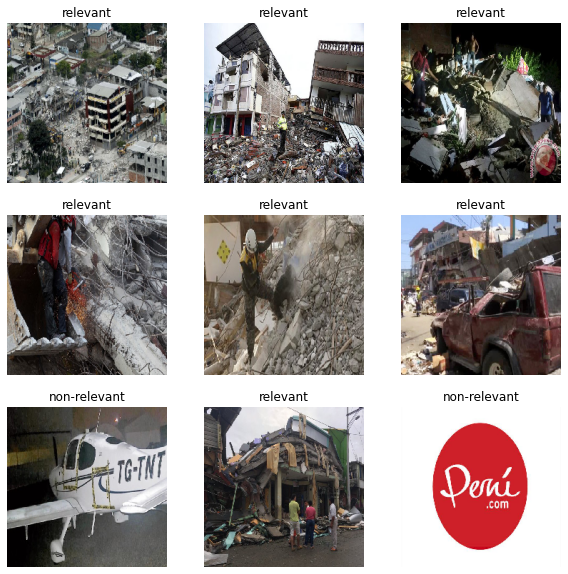

In [17]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[int(label)])
    plt.axis("off")

In [18]:
def subplot_learning_curve_d(history):
    #plt.clf()
    plt.figure(figsize=(10,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

## Model Building

In [19]:
from keras.applications.efficientnet import EfficientNetB0

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB0(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256,activation='relu')(x)
    outputs = layers.Dense(1,activation='sigmoid')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='binary_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

#instance of model
EfficientNetB0_h = get_efficient_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256) 

## Model Training

In [20]:
train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(DAMAGE_PATH,'relevance',
                                        is_augment=False,batch_size=20,buffer_size=100,frac=0.1)

Found 1464 validated image filenames.
Found 46 validated image filenames.
Found 46 validated image filenames.
steps_per_epochs: 74
validations_steps: 3


74/74 [==============================] - ETA: 0s - loss: 0.3961 - acc: 0.8204

C:\Users\wsn8\AppData\Local\conda\conda\envs\disaster-damage-assessment\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


74/74 [==============================] - 62s 764ms/step - loss: 0.3961 - acc: 0.8204 - val_loss: 0.3257 - val_acc: 0.8043


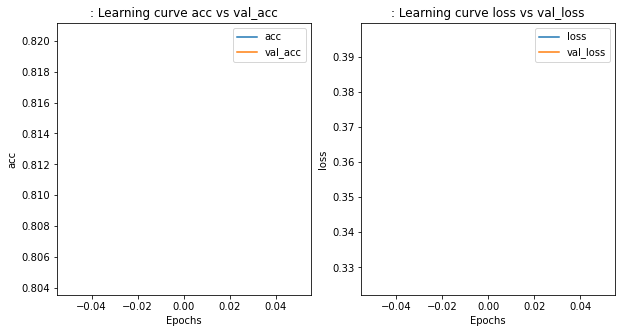

In [21]:
n_epochs = 1
output_path = os.path.join(cwd,'outputs','model')
exp_name = 'efficientnet_relevant_image'
check = callbacks.ModelCheckpoint(f'{output_path}/{exp_name}.h5',save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

history = EfficientNetB0_h.fit(train_ds,
                        epochs=n_epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_ds,
                        validation_steps = validation_steps,
                        callbacks=[check,early_stop])


subplot_learning_curve_d(history)

### Fine tuning

In [22]:
for layer in EfficientNetB0_h.layers:
    layer.trainable = True

EfficientNetB0_h.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
                       loss = 'binary_crossentropy',
                       metrics = ['acc'])
EfficientNetB0_h.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936

74/74 [==============================] - 223s 3s/step - loss: 0.2290 - acc: 0.9173 - val_loss: 0.3470 - val_acc: 0.8043


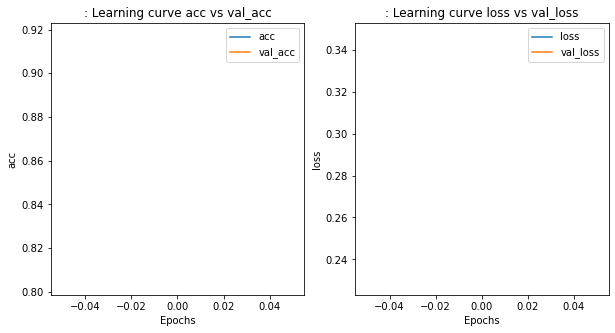

In [23]:
history_ft = EfficientNetB0_h.fit(train_ds,
                        epochs=n_epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_ds,
                        validation_steps = validation_steps,
                        callbacks=[check,early_stop])


subplot_learning_curve_d(history_ft)

## Model Evaluation

In [24]:
results_train = EfficientNetB0_h.evaluate(train_ds, steps=steps_per_epoch, return_dict=True)
results_train

74/74 [==============================] - 55s 744ms/step - loss: 0.2063 - acc: 0.9221


{'loss': 0.2063242793083191, 'acc': 0.9221311211585999}

In [25]:
results_valid = EfficientNetB0_h.evaluate(valid_ds, steps=validation_steps, return_dict=True)
results_valid

3/3 [==============================] - 2s 511ms/step - loss: 0.3470 - acc: 0.8043


{'loss': 0.3470022976398468, 'acc': 0.804347813129425}

In [26]:
results_test = EfficientNetB0_h.evaluate(test_ds, steps=validation_steps,return_dict=True)
results_test

3/3 [==============================] - 2s 607ms/step - loss: 0.2571 - acc: 0.9348


{'loss': 0.25705233216285706, 'acc': 0.9347826242446899}

In [ ]:
pd.DataFrame(data={'train':results_train,'valid':results_valid,'test':results_test}).T

## Visualize predictions

In [27]:
def decode_img(file_path):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = np.asarray(tf.cast(img, dtype=tf.float32)) * 1 / 255.0
  #img = tf.expand_dims(img, axis=0)
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [28]:
import numpy as np

def visualize_sample_test_predictions(event,n=12):

  images_path = os.path.join(cwd,'data/ASONAM17_Damage_Image_Dataset/')
  df_test = pd.read_csv(os.path.join(cwd,f"data/damage_csv/{event}/test.csv"))
  df_test_sample = df_test.sample(n=n)

  i = 0
  plt.figure(figsize = (20, 20))
  for index,row in df_test_sample.iterrows():
      ax = plt.subplot(4, 4, i + 1)
      filename = row[0]
      true_label= row[1]
      image_file = os.path.join(images_path,filename)
      img = decode_img(image_file)
      plt.imshow(img)
      img = tf.expand_dims(img, axis=0)
      preds = EfficientNetB0_h.predict(img)
      label = np.argmax(preds,axis=-1)
      title = f"label={class_names[int(true_label)]} - predict={class_names[int(label)]}"
      plt.title(title)
      plt.axis("off")
      i +=1
    

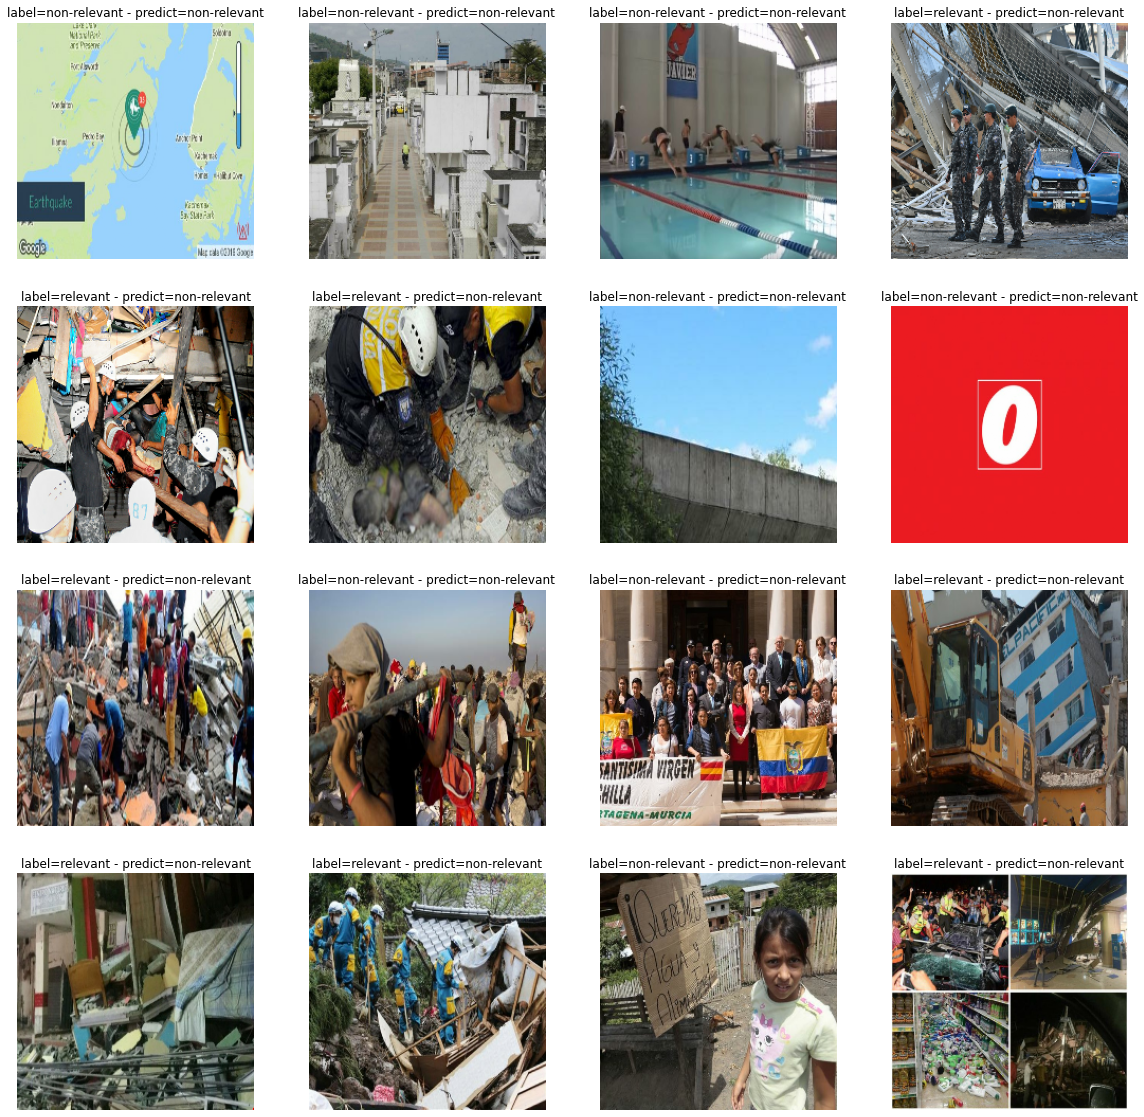

In [29]:
visualize_sample_test_predictions(event='relevance',n=16)  